In [55]:
#importing the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [56]:
import ssl
ssl.OPENSSL_VERSION

'OpenSSL 3.0.9 30 May 2023'

In [57]:
#importing the parquet data to pandas dataframe
df = pd.read_csv('cellular_dataframe.csv')

In [58]:
df.shape

(207434, 159)

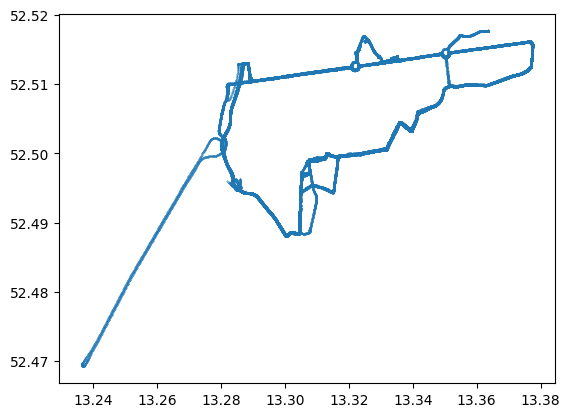

In [59]:
# plotting the scatter plot
plt.scatter(df['Longitude'], df['Latitude'], s=0.1)

In [60]:
# displaying the number of rows and columns
df.shape

(207434, 159)

In [61]:
telecom_data = df.__deepcopy__()
# remove nan values in latitudes and longitudes in telecom_data
telecom_data = telecom_data[~np.isnan(telecom_data['Latitude'])]
telecom_data = telecom_data[~np.isnan(telecom_data['Longitude'])]
#remove nan values in PCell_Downlink_Num_RBs, PCell_Downlink_TB_Size, SCell_Downlink_TB_Size and datarate
telecom_data = telecom_data[~np.isnan(telecom_data['PCell_Downlink_Num_RBs'])]
telecom_data = telecom_data[~np.isnan(telecom_data['PCell_Downlink_TB_Size'])]
telecom_data = telecom_data[~np.isnan(telecom_data['SCell_Downlink_TB_Size'])]
telecom_data = telecom_data[~np.isnan(telecom_data['SCell_Downlink_Num_RBs'])]
telecom_data = telecom_data[~np.isnan(telecom_data['SCell_Downlink_RBs_MCS_28'])]
telecom_data = telecom_data[~np.isnan(telecom_data['SCell_Downlink_RBs_MCS_31'])]
telecom_data = telecom_data[~np.isnan(telecom_data['PCell_RSRP_max'])]
telecom_data = telecom_data[~np.isnan(telecom_data['SCell_RSRP_max'])]
telecom_data = telecom_data[~np.isnan(telecom_data['datarate'])]
#normalizing the datarate using min-max normalization
telecom_data['datarate'] = ((np.max(telecom_data['datarate'])-telecom_data['datarate'])*100)/(np.max(telecom_data['datarate'])-np.min(telecom_data['datarate']))

df = telecom_data

In [62]:
df.shape

(3319, 159)

In [9]:
# plotting the coordinates on the map using folium
import folium

# creating a map
map = folium.Map(location=[52.5200, 13.4050], zoom_start=12)

# adding the coordinates to the map
for lat, lng in zip(df['Latitude'], df['Longitude']):
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7
    ).add_to(map)

# displaying the map
map

In [10]:
# saving the map
map.save('map.html')

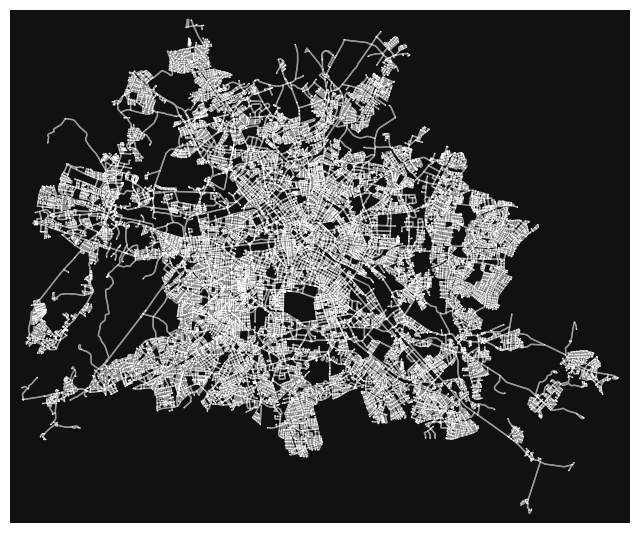

In [11]:
# importing berlin city map using osmnx
import osmnx as ox

# Specify the name of the city and country
place_name = "Berlin, Germany"

# Create a network from the boundaries of the specified place
graph = ox.graph_from_place(place_name, network_type='drive')

# save the plotted map as an image
fig, ax = ox.plot_graph(graph, save=True, show=True, node_size=1)

fig.savefig('berlin.png',dpi  = 3000)

In [12]:
route_nodes = []

# Get the nearest network nodes to all the lat long points
for i in range(len(df)):
    route_nodes.append(ox.distance.nearest_nodes(graph, df['Longitude'].iloc[i], df['Latitude'].iloc[i]))

print(route_nodes)

[21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 21677261, 27537749, 27537749, 27537749, 27537749, 27537749, 27537749, 27537749, 27537749, 252864802, 252864802, 252864802, 252864802, 252864802, 252864802, 252864802, 252864802, 252864802, 252864802, 1999948493, 27537749, 27537749, 27537749, 27537749, 2753774

In [13]:
# adding the nodeIDs to the dataframe
df['node_ids'] = route_nodes

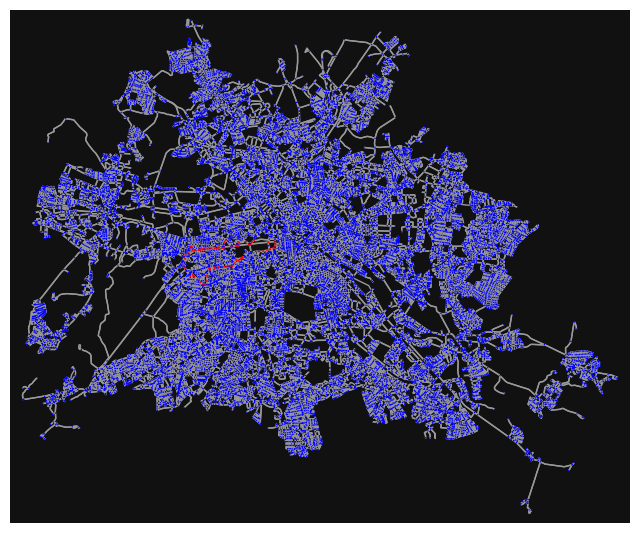

In [14]:
import osmnx as ox
# Get the node positions in a dictionary
node_positions = {node: (data['x'], data['y']) for node, data in graph.nodes(data=True)}

# Create a list of node colors
node_colors = ['r' if node in route_nodes else 'b' for node in graph.nodes()]

# Create a list of node sizes
node_sizes = [2 if node in route_nodes else 1 for node in graph.nodes()]

# Plot the graph
fig,ax = ox.plot_graph(graph,save =True, node_size=node_sizes, node_color=node_colors, node_zorder=2)

fig.savefig('route.png' ,dpi = 3000)

In [15]:
# selecting two random points from the dataframe
start = df.sample(n=1)
end = df.sample(n=1)

# getting the nodeIDs of the start and end points
start_node = start['node_ids'].iloc[0]
end_node = end['node_ids'].iloc[0]

# printing the start and end points
print(start_node, end_node)

26822713 26734501


In [16]:
# using k-shortest path algorithm to find the shortest paths
routes = ox.k_shortest_paths(graph, start_node, end_node, k=1000, weight='length')

In [21]:
routes = list(routes)

In [22]:
print([len(route) for route in routes])

[49, 55, 46, 58, 52, 57]


In [23]:
# removing the routes with more than 50% overlap using jaccard similarity
def remove_overlapping_routes(routes, overlap_threshold):
    non_overlapping_routes = []

    for route in routes:
        is_overlapping = False
        for existing_route in non_overlapping_routes:
            overlap = len(set(route).intersection(set(existing_route))) / len(set(route).union(set(existing_route)))
            if overlap > overlap_threshold:
                is_overlapping = True
                break
        if not is_overlapping:
            non_overlapping_routes.append(route)

    return non_overlapping_routes

routes = remove_overlapping_routes(routes, 0.50)


In [24]:
print([len(route) for route in routes])

[49, 55, 46, 58, 52, 57]


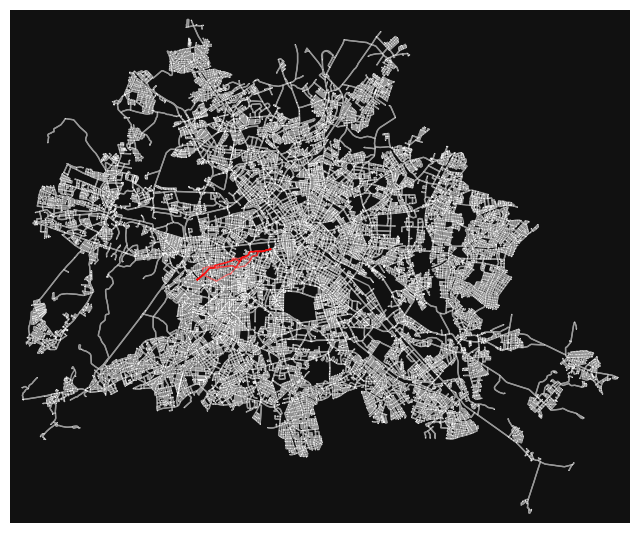

In [25]:
# display the paths found in the graph
# Plot the paths
fig,ax = ox.plot_graph_routes(graph, routes, route_colors='r', route_linewidths=1, node_size=0.5,**{'orig_dest_size':2})
fig.savefig('possible_routes.png' ,dpi = 3000)

# Finding Optimal Path using datarate prediction

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import haversine_distances
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

In [28]:
from torch_geometric.nn import SAGEConv
import pytorch_spiking

class ComplexGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ComplexGNN, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.conv3 = SAGEConv(hidden_dim, hidden_dim)
        self.conv4 = SAGEConv(hidden_dim, hidden_dim)
        self.conv5 = SAGEConv(hidden_dim, hidden_dim)
        self.conv6 = SAGEConv(hidden_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)  # Adding dropout for regularization

        # Defining the spiking activation
        self.spiking_activation = pytorch_spiking.SpikingActivation(torch.nn.ReLU(),dt=0.1)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.unsqueeze(2)  # Add a dummy dimension
        x = self.spiking_activation(x)
        x = x.squeeze(2)  # Remove the dummy dimension
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = x.unsqueeze(2)  # Add a dummy dimension
        x = self.spiking_activation(x)
        x = x.squeeze(2)  # Remove the dummy dimension
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = x.unsqueeze(2)  # Add a dummy dimension
        x = self.spiking_activation(x)
        x = x.squeeze(2)  # Remove the dummy dimension

        x = self.conv4(x, edge_index)
        x = x.unsqueeze(2)  # Add a dummy dimension
        x = self.spiking_activation(x)
        x = x.squeeze(2)  # Remove the dummy dimension
        x = self.dropout(x)

        x = self.conv5(x, edge_index)
        x = x.unsqueeze(2)  # Add a dummy dimension
        x = self.spiking_activation(x)
        x = x.squeeze(2)  # Remove the dummy dimension

        x = self.conv6(x, edge_index)
        x = x.unsqueeze(2)  # Add a dummy dimension
        x = self.spiking_activation(x)
        x = x.squeeze(2)  # Remove the dummy dimension
        
        x = self.linear1(x)
        x = x.unsqueeze(2)  # Add a dummy dimension
        x = self.spiking_activation(x)
        x = x.squeeze(2)  # Remove the dummy dimension
        
        x = self.linear2(x)

        return x

In [30]:
features = df[['PCell_Downlink_Num_RBs', 'PCell_Downlink_TB_Size', 'SCell_Downlink_TB_Size','SCell_Downlink_Num_RBs','SCell_Downlink_RBs_MCS_28','SCell_Downlink_RBs_MCS_31','PCell_RSRP_max','SCell_RSRP_max']].values

In [31]:
# Define your loss function and optimizer
gnn_model = ComplexGNN(input_dim=features.shape[1], hidden_dim=16, output_dim=1)
# loading a pytorch model from a saved state dict
gnn_model.load_state_dict(torch.load('lat_long_node_GNN_rsrp_spiking.pth'))

<All keys matched successfully>

In [63]:
def evaluate_model(telecom_data):
    # Extract relevant features and labels
    features = telecom_data[['PCell_Downlink_Num_RBs', 'PCell_Downlink_TB_Size', 'SCell_Downlink_TB_Size','SCell_Downlink_Num_RBs','SCell_Downlink_RBs_MCS_28','SCell_Downlink_RBs_MCS_31','PCell_RSRP_max','SCell_RSRP_max']].values
    labels = telecom_data['datarate'].values  # Replace 'label' with your actual label column
    
    # # Normalizing the labels using min-max normalization
    # labels = ((np.max(labels)-labels)*100)/(np.max(labels)-np.min(labels))
    
    # Extract latitudes and longitudes
    latitudes = telecom_data['Latitude'].values
    longitudes = telecom_data['Longitude'].values
    
    # Calculate pairwise distances using Haversine formula
    coordinates = np.column_stack((latitudes, longitudes))
    dist_matrix = haversine_distances(np.radians(coordinates))
    
    # Define distance threshold for edges
    distance_threshold = 1  # Consider nodes within specified distance as neighbors
    
    # Create adjacency matrix based on distance threshold
    adj_matrix = (dist_matrix <= distance_threshold).astype(int)
    
    # Convert adjacency matrix to edge indices
    edge_indices = np.transpose(np.nonzero(adj_matrix))
    edge_indices = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    
    loss_function = nn.MSELoss()
    
    X_train, y_train = features,labels
    y_train= y_train.reshape(-1,1)
    
    # Convert data to tensors
    x = torch.FloatTensor(X_train)
    y = torch.FloatTensor(y_train)
    
    # Create a graph data object using torch_geometric
    data = Data(x=x, edge_index=edge_indices, y=y)
    dataloader = DataLoader([data], batch_size=20)
    
    # Evaluation on test set
    gnn_model.eval()
    
    true_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for batch_data in dataloader:
            output = gnn_model(batch_data.x, batch_data.edge_index)
            
            true_labels.extend(batch_data.y.numpy())
            predicted_labels.extend(output.numpy())

    return true_labels,predicted_labels

In [53]:
import pandas as pd
import numpy as np

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two points on the Earth's surface.
    
    :param lat1: Latitude of point 1
    :param lon1: Longitude of point 1
    :param lat2: Latitude of point 2
    :param lon2: Longitude of point 2
    :return: Distance in kilometers
    """
    R = 6371.0  # radius of the Earth in kilometers

    d_lat = np.radians(lat2 - lat1)
    d_lon = np.radians(lon2 - lon1)

    a = (np.sin(d_lat / 2) * np.sin(d_lat / 2) +
         np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) *
         np.sin(d_lon / 2) * np.sin(d_lon / 2))
    
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

def find_nearest_latlong(df, lat, lon):
    """
    Find the nearest latitude and longitude in the dataframe to the given lat and lon.
    
    :param df: DataFrame containing latitude and longitude columns
    :param lat: Target latitude
    :param lon: Target longitude
    :return: DataFrame row with the nearest latitude and longitude
    """
    df['distance'] = df.apply(lambda row: haversine_distance(lat, lon, row['Latitude'], row['Longitude']), axis=1)
    nearest_row = df.loc[df['distance'].idxmin()]
    return pd.DataFrame([nearest_row])

# # Sample usage
# data = {
#     'latitude': [51.509865, 48.8566, 40.7128, 34.0522],
#     'longitude': [-0.118092, 2.3522, -74.0060, -118.2437],
#     'city': ['London', 'Paris', 'New York', 'Los Angeles']
# }
# df = pd.DataFrame(data)
# 
# result = find_nearest_latlong(df, 51.0, -0.5)
# print(result)


In [65]:
import networkx as nx
import osmnx as ox
import numpy as np

# Load your graph using OSMnx
G = graph



def predict_data_rate(node):
    req_latitude = node['y']
    req_longitude = node['x']
    req_df = find_nearest_latlong(df, req_latitude, req_longitude)
    expected_label,pred_datarate = evaluate_model(req_df)
    # print(expected_label,pred_datarate)
    return pred_datarate[0]

# Define a function to calculate combined cost
def combined_cost(node1, node2, alpha=0.5):
    data_rate = (predict_data_rate(node1) + predict_data_rate(node2)) / 2
    distance = ox.distance.great_circle_vec(node1['y'], node1['x'], node2['y'], node2['x'])
    cost = alpha * data_rate + (1 - alpha) * distance
    return cost

# List of paths (each path is a list of node IDs)
list_of_paths = routes

# Find the optimal path from the list using Dijkstra's algorithm and data rate prediction
best_path = None
max_cost = -float('inf')

for path in list_of_paths:
    total_cost = 0
    for i in range(len(path) - 1):
        node1 = G.nodes[path[i]]
        node2 = G.nodes[path[i + 1]]
        cost = combined_cost(node1, node2,alpha=1)
        total_cost += cost

    if total_cost > max_cost:
        max_cost = total_cost
        best_path = path

print("Best Path:", best_path)

Best Path: [26822713, 26869633, 26822368, 26745597, 10284285037, 1927043591, 26704112, 598609281, 26704113, 26703654, 26703655, 26704107, 26704106, 26704103, 197370459, 1321352940, 26704108, 26787971, 1643388781, 26763062, 26763015, 26762956, 26763054, 26704059, 26642105, 26704058, 26704549, 26704512, 26704513, 26763003, 26642106, 26731297, 26763053, 312215682, 26682643, 26731293, 26731295, 26731298, 26627423, 26682605, 26740541, 26662401, 26646231, 32531353, 26625325, 26734501]


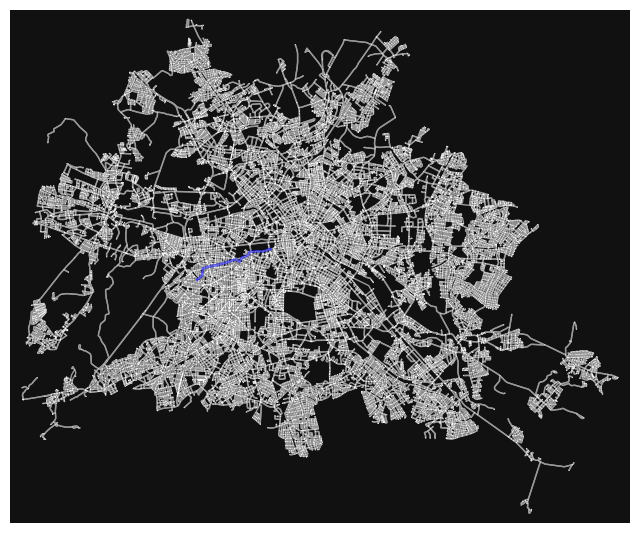

In [72]:
import osmnx as ox

# Assuming the following are already defined:
# graph: the network graph
# best_path: list of node values representing the best path

# First, plot the entire graph
fig, ax = ox.plot_graph(graph, node_size=0.5, show=False, close=False)

# Then, plot the best_path over it
ox.plot_graph_route(graph, best_path, route_color='blue', route_linewidth=2, orig_dest_size=2, ax=ax)

# Save the figure
fig.savefig('highlighted_best_path.png', dpi=3000)
